# Logistic regression

_description and hsitory in progress, see below for results_

Logistic regression is used to test the probability that a threshold value will be exceeded given the land-use configuration within a hex of 3 000 m including the distance to intersection and the length of all the intersecting rivers in a buffer.

__In the case of litter densities on lake shores we assume that the land-use adjacent to the survey location and magnitudes of local river inputs has an effect on the magnitude of trash found on the shore line__. In the previous sections we tested this hypothesis by using the ranked correlation test to measure the strength of the monotonic relationship between two variables: _survey results_ to _magnitude of the land use categories_. Logistic regression estimates the effect of the independent variables on the probability of an event occurring. In reference to shoreline litter densities we would like to know if (or to what degree) does land use effect the probability that a given density of litter (a threshhold value) will be encountered given the previous survey results and the land use configuration of a shoreline survey location.

## Odds and log odds

The odds of success are defined as the ratio of the probability of success divided by the probability of failure or $\frac{p}{1-p}$, where $p$ = the probability of success. Therfore, the log odds are _log(_$\frac{p}{1-p}$_)_. 

1. independent variables: km² of each land use category, km of roads, km of rivers, km to intersection point
2. outcome variable: binary, wether or not the threshold was exceeded at a survey
3. success: the threshold was exceeded

Since the outcome is a probability, the dependent variable is bounded between 0 and 1. In logistic regression, a logit transformation is applied on the odds of success, that is, the probability of success divided by the probability of failure. This is also commonly known as the log odds, or the natural logarithm of odds.

In [105]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time
from os import listdir
from os.path import isfile, join
import typing

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import beta
from scipy.stats import binom
from scipy import optimize
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import resources.landuse_config as luse
import resources.empiricaldist as emp

import time

def retrieve_locations_by_bin(data, columns=["use", "binned"], use="Fels"):
    d = data.groupby(columns, as_index=False).location.unique()
    return d.loc[d.use == use].dropna()

def count_nk_bin(data, locations, agg={"k":"sum","n":"sum", "n-k":"sum"}):
    return data.loc[locations].agg(agg)

def collect_bin_data(tested, xtest):
    use = xtest.use.unique()
    binned = xtest.binned.unique()
    locations = xtest.location.values
    
    bins = []
    
    for i, anarray in enumerate(locations):
        
        a_count = count_nk_bin(tested, anarray)
        a_count["use"] = use[0]
        a_count["binned"] = binned[i]
        bins.append(a_count)
    return bins

def n_and_k_for_a_set_of_landuse_data(tested, binned_land_use_data):
    
    binned = []
    for use in binned_land_use_data.use.unique():
        locations_by_bin = retrieve_locations_by_bin(binned_land_use_data, use=use)
        bin_totals = collect_bin_data(tested, locations_by_bin)
        
        binned += bin_totals
        
        
    df = pd.DataFrame(binned)
    df = df.groupby(["use", "binned"], as_index=False).agg({"k":"sum","n":"sum", "n-k":"sum"})
    return df

# scaled prior
def minimize_alpha_beta_beta(x, mu, var):
    
    alpha, beta = x[0], x[1]
    
    # define the mean and variance in terms of the parameters
    # mean or mu
    m = alpha/(alpha+beta)
    
    # standard deviation
    v =  (alpha*beta)/(((alpha+beta)**2)*(alpha+beta+1))
    
    return [m - mu, v - var]


# survey data:
dfBeaches = pd.read_csv("resources/beaches.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('location', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description.copy()

# shorten the descriptions of two codes
code_d_map.loc["G38"] = "sheeting for protecting large cargo items"
code_d_map.loc["G73"] = "Foamed items & pieces (non packaging/insulation)"

# code material map
code_m_map = dfCodes.material

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

cmap = sns.diverging_palette(230, 20, as_cmap=True)

df = pd.read_csv('resources/surveys_iqaasl.csv')

# the lakes of interest
# collection points would be a good
# label. This is how they are considered in the model
# these locations serve as the endpoint for many 
# small rivers
collection_points = [
    'zurichsee',
    'bielersee',
    'neuenburgersee',
    'walensee',
    'vierwaldstattersee',
    'brienzersee',
    'thunersee',
    'lac-leman',
    'lago-maggiore',
    'lago-di-lugano',
    'zugersee'
]

# the data-frame of survey results to be considered
features_of_interest = collection_points
df = df[df.feature.isin(features_of_interest)]

# test the survey results of an object of interest
# against a threshhold
code = "G27"
to_test = df[df.code == code].copy()
threshhold = to_test.pcs_m.median()

# map the location to the name of the lake
wn_map = df[["location", "feature"]].drop_duplicates("location").set_index("location")
wn_map = wn_map["feature"]


# The summary of the survey data
locations = df.location.unique()
samples = df.loc_date.unique()
lakes = df[df.w_t == "l"].drop_duplicates("loc_date").w_t.value_counts().values[0]
codes_identified = df[df.quantity > 0].code.unique()
codes_possible = df.code.unique()
total_id = df.quantity.sum()

data_summary = {
    "n locations": len(locations),
    "n samples": len(samples),
    "n lake samples": lakes,
    "n identified object types": len(codes_identified),
    "n possible object types": len(codes_possible),
    "total number of objects": total_id
}

pd.DataFrame(index = data_summary.keys(), data=data_summary.values()).style.set_table_styles(table_css_styles)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


,0
n locations,93
n samples,331
n lake samples,331
n identified object types,205
n possible object types,230
total number of objects,52269


## Setting up the data

### Aggregating, scaling and binning

In [106]:
# these are the land use values for each hex
# nutuzungsareal and freizeit areal are totaled
# the surface area of these two use cases gets added
# to the total of the land cover surface area
dfln = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-nutuzungsareal.csv")
dflf = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-freizeitareal.csv")

# rename the columns and total the surface are for each component
dflf.rename(columns={"OBJEKTART":"use"}, inplace=True)
dflf = dflf[~dflf.use.isin(['Reben', 'Obstanlage'])].copy()
dflf_t = dflf.groupby(["location", "river_bass", "city", "feature"], as_index=False).surface.sum()
dflf_t["use"] = "recreation"

dfln.rename(columns={"OBJEKTART":"use"}, inplace=True)
dfln = dfln[~dfln.use.isin(['Reben', 'Obstanlage'])].copy()
dfln_t = dfln.groupby(["location", "river_bass", "city", "feature"], as_index=False).surface.sum()
dfln_t["use"] = "infrastructure"

# combine the data frames
rec_inf = pd.concat([dfln_t, dflf_t])
rec_inf = rec_inf[rec_inf.location.isin(locations)]

# this is the land cover, the total surface area of the hex is accounted for here
# this includes the surface area of the lake within the hex
# there are portions of the map layer that have no land-use attribute
# to account for this, the total surface area of all labeled sections is 
# substracted from the area of a hex 5845672 m². This attribute is labled 
# undefined
dflc = pd.read_csv("resources/hex-3000m-cleaned/lake-locations-landcover.csv")

# sum the unique land cover values for each location
area_of_a_hex = 5845672
xgr = dflc.groupby(["location", "city", "river_bass","lat", "lon", "feature", "OBJVAL"], as_index=False).surface.sum()

# the sum of all the land cover values for a location
xgrt = xgr.groupby(["location", "city", "river_bass","lat", "lon", "feature"], as_index=False).surface.sum()

# the amount of surface area that is not accounted for 
xgrt["undefined"] = area_of_a_hex - xgrt.surface

# format data frame to join to the other land cover totals
xgrt["OBJVAL"] = "undefined"
xgrt["surface"] = xgrt["undefined"]
xgrt.drop("undefined", inplace=True, axis=1)

# add to other totals
dflcx = pd.concat([xgr, xgrt])

# remove the value of See from the surface area of a hex.
# We are considering the magnitude of land use type in relation
# to the amount of land that is available to be used, not including 
# amount of land that is covered by the lake itself
xsee = xgr[xgr.OBJVAL == "See"][["location", "surface"]]
xsee["hex minus"] = area_of_a_hex - xsee.surface
hex_minus = xsee[["location", "hex minus"]].set_index("location", drop=True)

# map the adjusted surface area to to the land use
# totals and scale the surface column to the adjusted surface area
dflcx["hex minus"] = dflcx.location.apply(lambda x: hex_minus.loc[x, "hex minus"])
# change column name
dflcx.rename(columns={"OBJVAL":"use"}, inplace=True)

# add the land use attributes to the land-cover data
rec_inf["hex minus"] = rec_inf.location.apply(lambda x: hex_minus.loc[x, "hex minus"])

columns = ["location", "river_bass", "city", "feature", "surface", "use", "hex minus"]

agg_land_use = pd.concat([dflcx[columns], rec_inf[columns]])

agg_land_use["scaled"] = agg_land_use.surface/agg_land_use["hex minus"]

# remove See from the data frame
agg_land_use = agg_land_use[agg_land_use.use != "See"]

# bin the scaled column
agg_land_use["binned"], bins = pd.cut(agg_land_use.scaled, bins=20, labels=np.arange(start=1, stop=21), retbins=True)

aglu = agg_land_use.copy()

### Testing the threshold

The cumulative results for each landuse attriute at the location.

In [107]:
# dftest = df[df.code == code].copy()
tested = luse.test_one_object(to_test, threshhold, "location")
f = n_and_k_for_a_set_of_landuse_data(tested, aglu)

aglu["k"] = aglu.apply(lambda row: f.loc[(f.use == row["use"])&(f.binned == row["binned"])].values[0][2], axis=1)
aglu["n"] = aglu.apply(lambda row: f.loc[(f.use == row["use"])&(f.binned == row["binned"])].values[0][3], axis=1)
aglu["n-k"] = aglu.apply(lambda row: f.loc[(f.use == row["use"])&(f.binned == row["binned"])].values[0][4], axis=1)

# dropping the duplicates of use and binned leaves
# the combinations for all the landuse features for all
# locations defined by the data frame.
# The median value is the threshold that is being tested.
# therefore the k/n by landuse feature should be very close
# to k/n for all the survey results
aglu[aglu.location == 'grand-clos']

,location,river_bass,city,feature,surface,use,hex minus,scaled,binned,k,n,n-k
81,grand-clos,rhone,Saint-Gingolph,lac-leman,781161,Siedl,2866287,0.272534,6,5,18,13
82,grand-clos,rhone,Saint-Gingolph,lac-leman,1377510,Wald,2866287,0.480590,10,7,16,9
21,grand-clos,rhone,Saint-Gingolph,lac-leman,707616,undefined,2866287,0.246875,5,19,39,20
37,grand-clos,rhone,Saint-Gingolph,lac-leman,42876,infrastructure,2866287,0.014959,1,103,224,121
37,grand-clos,rhone,Saint-Gingolph,lac-leman,95036,recreation,2866287,0.033156,1,127,260,133


#### The odds and frequency of exceeding the threshold

Recall the definition of odds an frequency

In [115]:
# The land use features can be classifed according
# how likely the threshold was exceeded given the magnitide
# of the land use feature

# drop all duplicate values of use and binned

def collect_odds_frequency(data):
    data["odds"] = data["k"]/data["n-k"]
    data["frequency"] = data["k"]/data["n"]
    
    return data

def land_use_odds_frequency(data, rb, feature, location):
    agg_cols = {"k":"sum", "n": "sum", "n-k": "sum"}
    
    dall = data.drop_duplicates(["use", "binned"])
    dall = dall.groupby("use").agg(agg_cols)
    dall = collect_odds_frequency(dall)
    
    drb = data[data.river_bass == rb].drop_duplicates(["use", "binned"])
    drb = drb.groupby("use").agg(agg_cols)
    drb = collect_odds_frequency(drb)
    
    dfeat = data[data.feature == feature].drop_duplicates(["use", "binned"])
    dfeat = dfeat.groupby("use").agg(agg_cols)
    dfeat = collect_odds_frequency(dfeat)
    
    dloc = data[data.location == location].drop_duplicates(["use", "binned"])
    dloc = dloc.groupby("use").agg(agg_cols)
    dloc = collect_odds_frequency(dloc)
    
    return dall, drb, dfeat, dloc

def summary_table_odds_frequency(dall, drb, dfeat, dloc, column="odds", labels=["all data", "rb", "feature", "location"]):    
    
    dall.rename(columns={column:labels[0]}, inplace=True)
    drb.rename(columns={column:labels[1]}, inplace=True)
    dfeat.rename(columns={column:labels[2]}, inplace=True)
    dloc.rename(columns={column:labels[3]}, inplace=True)
    summary_odds = pd.concat([dall[labels[0]], drb[labels[1]], dfeat[labels[2]], location[labels[3]]], axis=1).fillna(0)
    
    return summary_odds

    
aglu_totals = aglu.drop_duplicates(["use", "binned"])

all_data, r_bas, feature, location = land_use_odds_frequency(aglu, 'aare', 'bielersee', 'mullermatte')

summary_odds = summary_table_odds_frequency(all_data, r_bas, feature, location, column="odds", labels=["all data", "aare", "bielersee", "mullermatte"])
summary_odds.index.name = None
sodds = summary_odds.style.format(precision=2) # 
sodds.background_gradient(axis=None, vmin=0, vmax=summary_odds.max().max(), cmap='YlOrBr')

,all data,aare,bielersee,mullermatte
Fels,0.68,0.70,2.00,0.00
Obstanlage,0.73,0.35,0.33,0.00
Reben,0.97,1.04,1.04,0.00
Siedl,0.97,0.90,0.59,3.67
Stadtzentr,1.94,1.81,1.86,1.86
Sumpf,0.40,0.41,0.07,0.00
Wald,0.92,0.68,0.52,0.82
infrastructure,0.97,0.92,0.92,0.85
recreation,0.97,0.97,0.95,0.95
undefined,0.97,0.99,0.95,2.20


In [120]:
feature.sum()

k             554.000000
n            1227.000000
n-k           673.000000
bielersee       9.225952
frequency       4.306077
dtype: float64

#### The probability of exceeding the threshold

Recall the beta-binomial conjugate 

In [138]:
# the prior of all the data
# there is an expectation that the
# results will be in the neighborhood of
# the median or 0.5
# xs = np.linspace(0, 1, 101)
# prior = emp.Pmf(1, xs)
# likelihood = binom.pmf(1, 2, xs)
# posterior = likelihood * prior
# posterior.normalize()
# print(posterior.credible_interval(.96), posterior.mean())

def make_beta(k, n_minus_k):
    """Makes a beta object."""
    dist = beta(k, n_minus_k)
    dist.alpha = k
    dist.beta = n_minus_k
    return dist
def update_beta(prior, data):
    """Update a beta distribution."""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

def getAlphaBeta(mu, sigma):
    alpha = mu**2 * ((1 - mu) / sigma**2 - 1 / mu)

    beta = alpha * (1 / mu - 1)

    return alpha, beta

def update_the_beta_for_a_code(prior, data, scale: bool=True, start_scale = [1, 1]):
    
    k, n = data
    if scale:
        mu = data[0]/data[1]
        var = (data[0]*(data[1] - data[0]))/((data[0] + (data[1]-data[0]))**2*(data[0] + (data[1]-data[0]) + 1))
        if var < 0.01:
            var = 0.01
            
        a,b = getAlphaBeta(mu, var)
        kscaled, nscaled = optimize.root(minimize_alpha_beta_beta, start_scale, args=(mu, var)).x
        print(k,n, kscaled, nscaled, a,b, mu, var)
        return k,n, kscaled, nscaled, a,b, mu, var
                                             
    
prior_beta = make_beta(1, 1)

In [139]:
k,n, kscaled, nscaled, a,b, mu, var = update_the_beta_for_a_code(prior, (554, 1227))

554 1227 10.730013816669155 13.03483627916424 1117.7006481758335 1357.7843614121587 0.4515077424612877 0.01


In [141]:
print(k/(n-k), kscaled/nscaled, a/b)

0.8231797919762258 0.8231797919718202 0.8231797919762259


In [140]:



# get the mean from the lake posterior and set variance to a limit
mu = test_mediank/test_mediann
var = 0.01

# alpha beta minimized
scaled = optimize.root(minimize_alpha_beta_beta, [1, 1], args=(mu, var)).x



def make_beta(k, n_minus_k):
    """Makes a beta object."""
    dist = beta(k, n_minus_k)
    dist.alpha = k
    dist.beta = n_minus_k
    return dist
def update_beta(prior, data):
    """Update a beta distribution."""
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)
prior_beta = make_beta(1, 1)

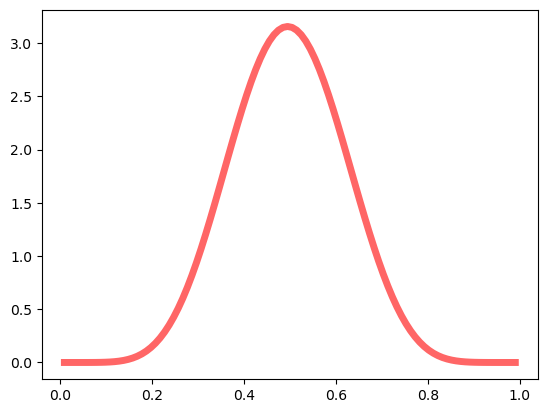

<Axes: >

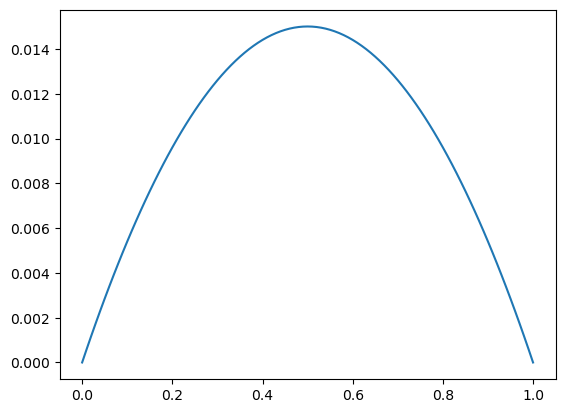

In [151]:
posterior.plot()

In [165]:
# the locations of interest
locations = df[df.feature == "lac-leman"].location.unique()

# the the survey results for the location
current = tested.loc[locations]

# this is P(theta|landuse_i)  where landuse is only concerned with
# locations of a given feature.
by_feature = dflcx[dflcx.feature == "lac-leman"].drop_duplicates(["use", "binned"])

# k, n and n-k for the feature landuse values
# where k is exceeded threshold
# by_feature[["k", "n", "n-k"]].sum()
ft = by_feature[["k", "n", "n-k"]].sum()
kl_nl = ft["k"]/ft["n"]
print(ft)

# get the mean from the lake posterior and set variance to a limit
mu = kl_nl
var = 0.01

# alpha beta minimized
scaled = optimize.root(minimize_alpha_beta, [1,1], args=(mu, var)).x
nlake, klake = round(scaled[1]), round(scaled[0])
xlake = binom.pmf(klake, nlake, xs)
print(scaled)

post_l = posterior*xlake
post_l.normalize()
print(post_l.credible_interval(.96), post_l.mean())

k      401
n      810
n-k    409
dtype: int64
[ 7.00287595 14.14546015]
[0.27 0.73] 0.5


<Axes: >

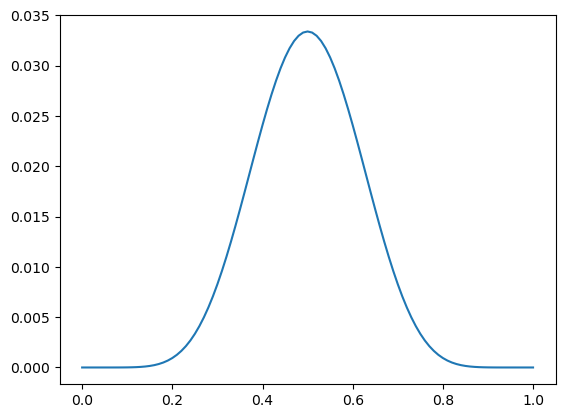

In [153]:
post_l.plot()

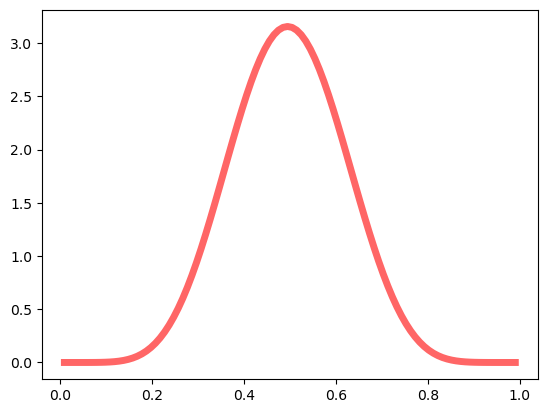

In [172]:
fig, ax=plt.subplots()
new_beta = update_beta(prior_beta, (7.002, 14.145))
x = np.linspace(0.01, 0.99, 100)
ax.plot(x, new_beta.pdf(x), 'r-', lw=5, alpha=0.6, label='beta pdf')

In [154]:
ftx = by_feature.groupby(["use", "binned"]).agg({"k": "sum", "n":"sum", "n-k":"sum"})
ftx.loc["Siedl"].sum()
lake_features = by_feature.use.unique()

priors = [posterior.copy() for x in lake_features]

collected = []

for i, afeature in enumerate(lake_features):    
  
    summed = ftx.loc[afeature].sum()
    k = summed["k"]
    n = summed["n"]
    k_over_n = k/n   
   
    likelihood = binom.pmf(k, n, xs)
    post = priors[i] * likelihood
    post.normalize()
    
    collected.append(post)

In [169]:
# the oserved n, k, n-k for the feature
t = tested.loc[locations][["k", "n", "n-k"]].sum()
klake, nlake = t["k"], t["n"]
mu = klake/nlake
var = 0.01
print(klake, nlake)

scaled = optimize.root(minimize_alpha_beta, [1,1], args=(mu, var)).x
sn, sk = round(scaled[1]), round(scaled[0])
xlakes = binom.pmf(sk, sn, xs)
print(scaled)

post_lk = post_l*xlakes
post_lk.normalize()
print(post_lk.credible_interval(.96), post_lk.mean())

63 98
[ 8.92898825 13.88953727]
[0.38 0.73] 0.5625


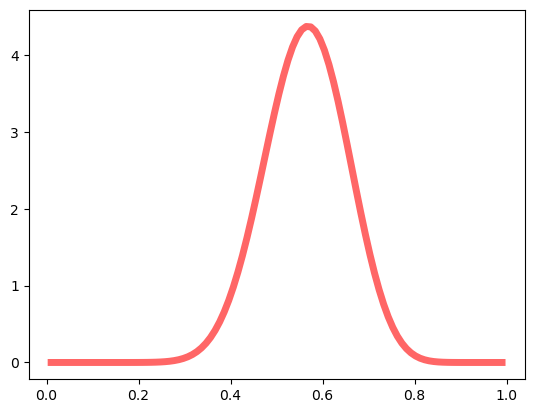

In [173]:
new_beta = update_beta(new_beta, (8.928, 13.889))
fig, ax=plt.subplots()
x = np.linspace(0.01, 0.99, 100)
ax.plot(x, new_beta.pdf(x), 'r-', lw=5, alpha=0.6, label='beta pdf')

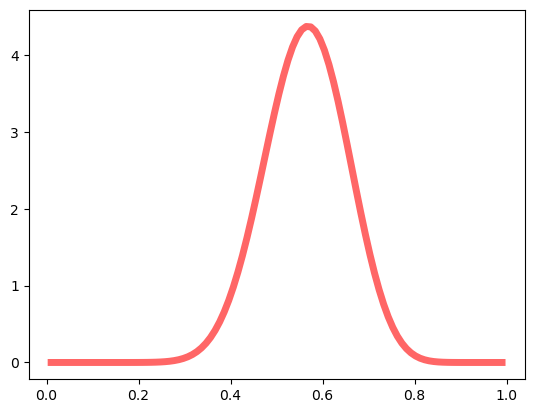

In [176]:

fig, ax=plt.subplots()
x = np.linspace(0.01, 0.99, 100)
y = [new_beta.pdf(j) for j in x]
ax.plot(x, y, 'r-', lw=5, alpha=0.6, label='beta pdf')


<Axes: >

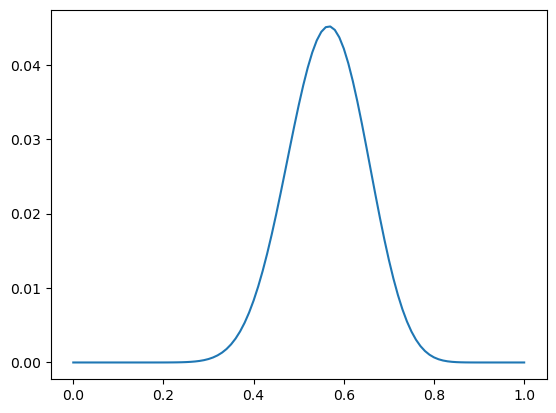

In [177]:
post_lk.plot()

In [178]:
# k given the landuse conditions at the location
t_l = dflcx[dflcx.location == 'villa-barton'][["k", "n", "n-k"]].sum()
klake, nlake = t_l["k"], t_l["n"]
mu = klake/nlake
scaled = optimize.root(minimize_alpha_beta, [1,1], args=(mu, var)).x
sn, sk = round(scaled[1]), round(scaled[0])
xlakes = binom.pmf(sk, sn, xs)

post_lk *= xlakes
post_lk.normalize()
print(post_lk.credible_interval(.96), post_lk.mean())

[0.39 0.69] 0.5434782608695652


In [179]:
t_loc = tested.loc['quai-maria-belgia']
klake, nlake = t_loc["k"], t_loc["n"]
xlakes = binom.pmf(klake, nlake, xs)

post_lk *= xlakes
post_lk.normalize()
print(post_lk.credible_interval(.96), post_lk.mean())

[0.42 0.68] 0.5517241379310345


<Axes: >

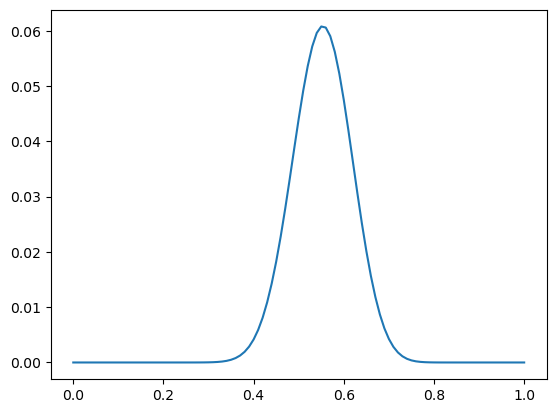

In [69]:
post_lk.plot()

In [70]:
# found at that location
current.loc['quai-maria-belgia']

k       7.000000
n      12.000000
n-k     5.000000
k/n     0.583333
Name: quai-maria-belgia, dtype: float64

In [71]:
# what is the probability of exceeding the national median for
# for the given code, location, feature 
# p for the feature, the prior is the expected chance of y > median: 0.5
prior = 0.5
fk = feature_totals["k"]
fn = feature_totals["n"]
nminusk = feature_totals["n-k"]
h_one = (fk/fn)*prior
odds_feature = fk/nminusk

h_not = (nminusk/fn)*(1-prior)

tp = h_one + h_not
posterior =  h_one/tp
# print(tp, h_one, h_not, h_one/tp, h_not/tp, odds_feature)
print(f'k/n: {fk/fn}, n-k/n: {nminusk/fn}, posterior: {posterior}')

NameError: name 'feature_totals' is not defined

In [21]:
# probability at the location
location_totals = dflcx[dflcx.location == 'grand-clos'][["k", "n", "n-k"]].sum()
lk = location_totals["k"]
ln = location_totals["n"]
l_not = location_totals["n-k"]

In [11]:
def conditions_at_location(data):
    # meters squared
    ms2 = data[["use", "surface"]].set_index("use")/1000000    
    
    cv = data[["use", "binned"]].set_index("use")
    conditions = []
    
    for ause in data.use.unique():
        a_bin_number = cv.loc[ause, "binned"]
        a_bin_ranking = bins[a_bin_number]
        arange = [bins[(a_bin_number-1)], bins[a_bin_number]]
        conditions.append((ause, a_bin_number, a_bin_ranking, arange))
        
    return conditions, ms2


quantile_bin, surface_area = conditions_at_location(col)

In [2]:
my_path=  "resources/hex-3000m-cleaned"

columns = [
    "river_bass",
    "location", 
    "city",
    "feature"
]

column_rename = {"undefined":"Undefined"}
area_of_a_hex = 5845672
id_vals = ["location", "OBJVAL"]
agg_val = "surface"

data_map_name = "lake-locations-landcover"

lc_groups = [
    'Siedl',
    'Undefined',
    'Wald'
]

lc_presence = [
    'Obstanlage',
    'Reben',
    'Stadtzentr',
    'Sumpf',
    'Fels'
]

groups_and_presence = [*lc_groups, *lc_presence]
       
merge_column = gby_column = "location"
merge_method = 'outer'
merge_validate = "many_to_one"
quantiles =   [0,.1, .25, .5, .75, .9, 1]
        
# label the region of interest
# this creates a hierarcal group of the locations
# that are within a region. The most common would be lake
regional_label = "lake"
label_map = wn_map

# collect the data
data_map = luse.collect_feature_data(path_to_data=my_path)
land_cover_data = data_map[data_map_name]
land_cover_data.rename(columns=column_rename, inplace=True)

# limit the data to the parameters of interest
land_use_kwargs = {
    "data_map":land_cover_data,
    "locations":locations,
    "region":None,
    "columns":columns,
    "id_vals": id_vals,
    "dim_oi": area_of_a_hex,
    "to_aggregate":agg_val,
    "land_use_groups":lc_groups,
}

test_kwargs = {
    "df":to_test,
    "threshhold":threshhold,
    "merge_column":merge_column,
    "merge_method":merge_method,
    "merge_validate":merge_validate,
    "groups":lc_groups,
    "presence":lc_presence,
    "quantiles":quantiles
}

inf_operation = {"k":"sum", "n":"sum"}

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': None,
    'assign_undefined': True,
    'length': False,
    'cover': True,
    'inf_operation': inf_operation,
    'regional_label': regional_label,
    'label_map': label_map,
    'total': False
}


nx = luse.LanduseConfiguration(**kwargs)
nx.groups_and_presence()
nx.inference_groups()
nxf = nx.grouped_data
nx_conf = nx.labeled_groups

# add the data from another land use layer
# the results will be added to the landcover data frame
label = "strasse"
data_map_name = 'lake-locations-strasse'
id_vals = ["location", "OBJEKTART"]
agg_val = "length"

# identify the columns of interest
st_groups = [
    '10m Strasse',
    '1m Weg',
    '1m Wegfragment',
    '2m Weg',
    '2m Wegfragment',
    '3m Strasse',
    '4m Strasse',
    '6m Strasse',
    '8m Strasse',
    'Ausfahrt',
    'Autobahn',
    'Autostrasse',
    'Dienstzufahrt',
    'Einfahrt',
    'Faehre',
    'Markierte Spur',
    'Platz',
    'Raststaette', 'Verbindung', 'Zufahrt'
]

st_presence = []

groups_and_presence = [*st_groups, *st_presence]

# collect the data
street_lengths_data = data_map[data_map_name]

# update the key word arguments for the land use data
land_use_update = dict(data_map=street_lengths_data, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=st_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=st_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': 'strasse',
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': None,
    'total': True
}

strasse = luse.LanduseConfiguration(**kwargs)

strasse.groups_and_presence()
strasse.inference_groups()
sxf = strasse.grouped_data
sx_conf = strasse.labeled_groups
strasse_config = strasse.configuration_keys

# add the data from another land use layer
# the results will be added to the landcover data frame
# column_rename = {"undefined":"Undefined"}
data_map_name = 'lake-locations-freizeitareal'
id_vals = ["location", "OBJEKTART"]
agg_val = "surface"
columns = [
    "river_bass",
    "location",
    "city",
    "feature"
]

recreation_data = data_map[data_map_name]
# identify the columns of interest
rec_groups = recreation_data.OBJEKTART.unique()
rec_presence = []

groups_and_presence = [*rec_groups, *rec_presence]
# update the key word arguments for the land use data
land_use_update = dict(data_map=recreation_data, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=rec_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=rec_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': 'recreation',
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': None,
    'total': True
}

recreation = luse.LanduseConfiguration(**kwargs)
recreation.groups_and_presence()
recreation.inference_groups()
rec_config = recreation.configuration_keys

# add the data from another land use layer
# the results will be added to the landcover data frame
data_map_name = 'lake-locations-nutuzungsareal'
id_vals = ["location", "OBJEKTART"]
agg_val = "surface"

columns = [
    "river_bass",
    "location", 
    "city",
    "feature"
]


infrastructure_data = data_map[data_map_name]

# identify the columns of interest
inf_groups = infrastructure_data.OBJEKTART.unique()
inf_presence = []

groups_and_presence = [*inf_groups, *inf_presence]
# update the key word arguments for the land use data
land_use_update = dict(data_map=infrastructure_data, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=inf_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=inf_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': 'infrastructure',
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': None,
    'total': True
}

infrastructure = luse.LanduseConfiguration(**kwargs)
infrastructure.groups_and_presence()
infrastructure.inference_groups()
inra_config = infrastructure.configuration_keys

data_map_name = 'resources/hex-3000m-cleaned/river-intersect-length.csv'
intersections = pd.read_csv(data_map_name)
n_c_names = {
    "KLASSE": 'class',
    "NAMN": 'name',
    "BREITE": 'size',
}
intersections.rename(columns=n_c_names, inplace=True)

intersections = intersections.drop_duplicates(["location", "name"])
dints = intersections.groupby("location").distance.sum()
nints = intersections.groupby("location").distance.nunique()
ints_d = pd.DataFrame(dints/nints).reset_index()
ints_d = pd.melt(ints_d, id_vars="location", value_vars="distance").fillna(0)

river_length = intersections.copy()
river_length = river_length.drop_duplicates(["location", "name"])
nlen = river_length.groupby("location").length.nunique()
llen = river_length.groupby("location").length.sum()
lengths_d = pd.DataFrame(llen/nlen).reset_index()
len_d = pd.melt(lengths_d, id_vars="location", value_vars="length").fillna(0)

id_vals = ["location", "variable"]
agg_val = "value"
inf_groups = ["distance"]
inf_presence = []

groups_and_presence = [*inf_groups, *inf_presence]



# update the key word arguments for the land use data
land_use_update = dict(data_map=ints_d, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=inf_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=inf_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': "r-distance",
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': label_map,
    'total': True
}

distance = luse.LanduseConfiguration(**kwargs)
distance.groups_and_presence()
distance.inference_groups()
dist_conf = distance.configuration_keys

id_vals = ["location", "variable"]
agg_val = "value"
inf_groups = ["length"]
inf_presence = []

groups_and_presence = [*inf_groups, *inf_presence]

# update the key word arguments for the land use data
land_use_update = dict(data_map=len_d, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=inf_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=inf_groups, presence=None)
test_kwargs.update(test_update)



kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': "r-length",
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': label_map,
    'total': True
}

intersections = luse.LanduseConfiguration(**kwargs)
intersections.groups_and_presence()
intersections.inference_groups()
int_conf = intersections.configuration_keys

# add results for land use to land cover 
# drop the conf column
fgl = nx_conf.drop("conf", axis=1)

fgl['infrastructure'] = fgl.location.apply(lambda x: inra_config.loc[x][0][0])
fgl['strasse'] = fgl.location.apply(lambda x: strasse_config.loc[x][0][0])
fgl['recreation'] = fgl.location.apply(lambda x: rec_config.loc[x][0][0])
fgl['r-length'] = fgl.location.apply(lambda x: int_conf.loc[x][0][0])
fgl['r-distance'] = fgl.location.apply(lambda x: dist_conf.loc[x][0][0])
fgl = fgl.fillna(0)
# define the confiugration columns
conf_columns = [*lc_groups, *lc_presence, 'infrastructure', 'strasse', 'recreation', 'r-length', 'r-distance']
fgl['configuration'] = list(zip(*[fgl[x] for x in conf_columns]))
fgl_conf_keys = fgl[["location", "configuration"]].set_index("location")

# update the probability tables
fgl_ptables =nx.p_tables
fgl_ptables.update(infrastructure.p_tables)
fgl_ptables.update(recreation.p_tables)
fgl_ptables.update(strasse.p_tables)
fgl_ptables.update(intersections.p_tables)
fgl_ptables.update(distance.p_tables)

inference_kwargs = {
    'location': " ",
    'lake': "",
    'conf_label': 'configuration',
    'fgl_conf_keys':fgl_conf_keys,
    'conf_columns': conf_columns,
    'p_tables': fgl_ptables,
    'tested':nx.grouped_data,
    'prior':None,
    'drop_vals': None
}



bsee_l = nx.grouped_data[nx.grouped_data.lake.isin(features_of_interest)].location.unique()
res = []
for alocation in bsee_l:
    inference_kwargs.update({"location":alocation})
    p=luse.inference_for_one_location(**inference_kwargs)
    res.append({'location':alocation, 'p':p})

lct = nx.test_results.test_and_merge()
sct = strasse.test_results.test_and_merge(cover=False)
rct = recreation.test_results.test_and_merge(cover=False)
ict = infrastructure.test_results.test_and_merge(cover=False)
dist_ct = distance.test_results.test_and_merge(cover=False)
ints_ct = intersections.test_results.test_and_merge(cover=False)

dfs = [lct, sct, rct, ict, dist_ct, ints_ct]

p_of = pd.DataFrame(res)

## What is the chance of exceeding the median?

The land use data for each location is tested with respect to the survey results for a given object.

1. Object: Gfrags, fragmented plastics > 0.5 mm
2. The median value of all the data is 0.23 pieces per meter

Each graph represents the 

In [15]:
import statsmodels.formula.api as smf
from scipy.special import expit
to_test["failed"] = (df.pcs_m > threshhold).astype('int')
log_of = to_test[["location", "failed"]].copy()
log_of["infrastructure"] = log_of.location.apply(lambda x: ict.loc[ict.location == x, "infrastructure"].values[0])
log_of["infrastructure"] = log_of.infrastructure/1000000

obj_min, obj_max = log_of.infrastructure.min(), log_of.infrastructure.max()

formula = 'failed ~ infrastructure'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['infrastructure']
xs = np.arange(obj_min, obj_max, step=.01)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

In [17]:
odds = np.exp(log_odds)
psx = odds/(odds +1)
psx.mean()

0.7627753821286635

In [18]:
ps_x.mean()

0.7627753821286635

In [14]:
log_of.head()

,location,failed,infrastructure
86941,aabach,0,0.034218
86951,anarchy-beach,1,0.125406
86952,ascona-traghetto-spiaggia,1,0.127192
86953,augustmutzenbergstrandweg,0,0.157734
86954,baby-plage-geneva,1,0.699988


### Infrastructure

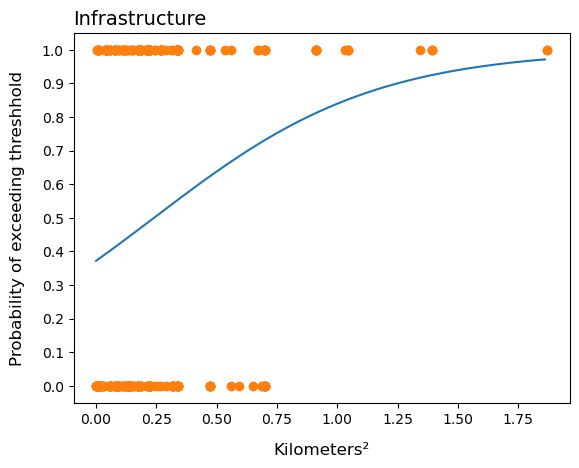

In [3]:
import statsmodels.formula.api as smf
from scipy.special import expit
to_test["failed"] = (df.pcs_m > threshhold).astype('int')
log_of = to_test[["location", "failed"]].copy()
log_of["infrastructure"] = log_of.location.apply(lambda x: ict.loc[ict.location == x, "infrastructure"].values[0])
log_of["infrastructure"] = log_of.infrastructure/1000000

obj_min, obj_max = log_of.infrastructure.min(), log_of.infrastructure.max()

formula = 'failed ~ infrastructure'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['infrastructure']
xs = np.arange(obj_min, obj_max, step=.01)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["infrastructure"], log_of["failed"], 'o')
ax.set_title("Infrastructure", fontsize=14, loc='left')

ax.set_xlabel("Kilometers²", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Urbanization

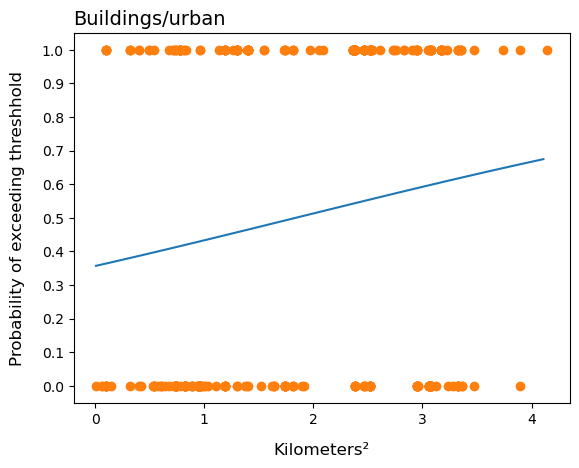

In [4]:
log_of = to_test[["location", "failed"]].copy()
log_of["Siedl"] = log_of.location.apply(lambda x: lct.loc[lct.location == x, "Siedl"].values[0])
log_of["Siedl"] = log_of.Siedl/1000000

obj_min, obj_max = log_of.Siedl.min(), log_of.Siedl.max()

formula = 'failed ~ Siedl'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Siedl']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["Siedl"], log_of["failed"], 'o')
ax.set_title("Buildings/urban", fontsize=14, loc='left')

ax.set_xlabel("Kilometers²", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Forest

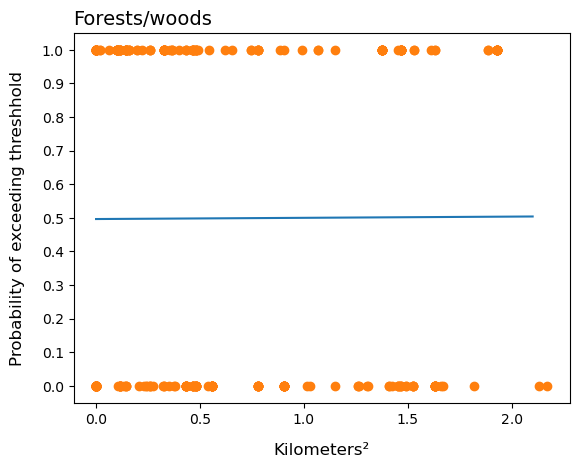

In [5]:
log_of = to_test[["location", "failed"]].copy()
log_of["Wald"] = log_of.location.apply(lambda x: lct.loc[lct.location == x, "Wald"].values[0])
log_of["Wald"] = log_of.Wald/1000000

obj_min, obj_max = log_of.Wald.min(), log_of.Wald.max()

formula = 'failed ~ Wald'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Wald']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["Wald"], log_of["failed"], 'o')
ax.set_title("Forests/woods", fontsize=14, loc='left')

ax.set_xlabel("Kilometers²", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Undefined

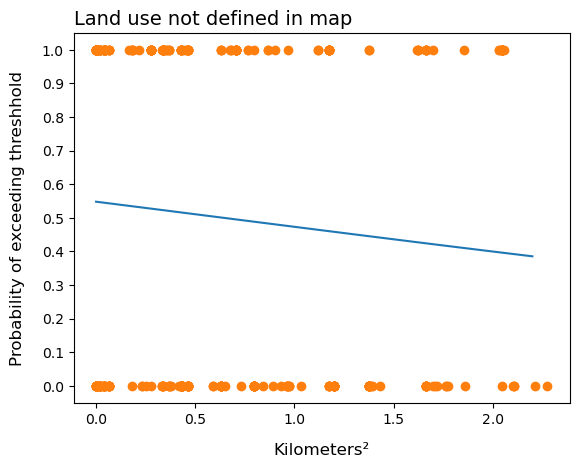

In [6]:
log_of = to_test[["location", "failed"]].copy()
log_of["Undefined"] = log_of.location.apply(lambda x: lct.loc[lct.location == x, "Undefined"].values[0])
log_of["Undefined"] = log_of.Undefined/1000000

obj_min, obj_max = log_of.Undefined.min(), log_of.Undefined.max()

formula = 'failed ~ Undefined'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Undefined']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["Undefined"], log_of["failed"], 'o')
ax.set_title("Land use not defined in map", fontsize=14, loc='left')

ax.set_xlabel("Kilometers²", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Recreation

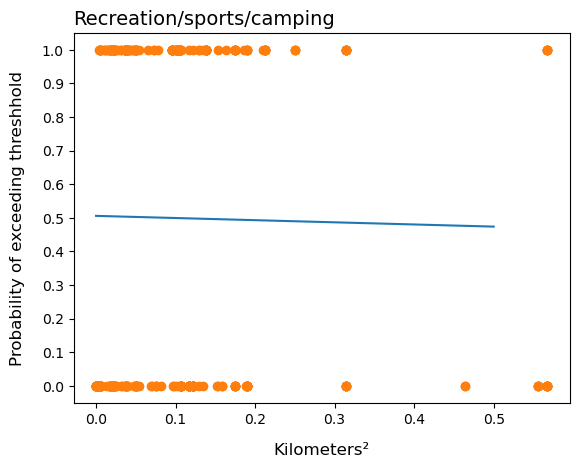

In [7]:
log_of = to_test[["location", "failed"]].copy()
log_of["recreation"] = log_of.location.apply(lambda x: rct.loc[rct.location == x, "recreation"].values[0])
log_of["recreation"] = log_of.recreation/1000000

obj_min, obj_max = log_of.recreation.min(), log_of.recreation.max()

formula = 'failed ~ recreation'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['recreation']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["recreation"], log_of["failed"], 'o')
ax.set_title("Recreation/sports/camping", fontsize=14, loc='left')

ax.set_xlabel("Kilometers²", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Distance to river intersection

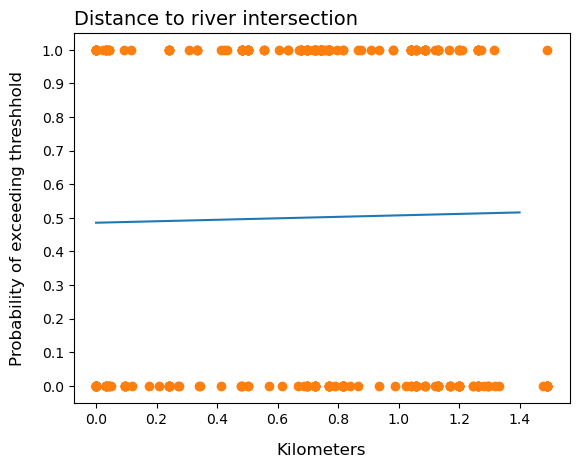

In [8]:
log_of = to_test[["location", "failed"]].copy()

log_of["r-distance"] = log_of.location.apply(lambda x: dist_ct.loc[dist_ct.location == x, "r-distance"].values[0])
log_of["r-distance"] = log_of["r-distance"]/1000
log_of.rename(columns={'r-distance':'r_distance'}, inplace=True)

obj_min, obj_max = log_of["r_distance"].min(), log_of["r_distance"].max()

formula = 'failed ~ r_distance'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['r_distance']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["r_distance"], log_of["failed"], 'o')
ax.set_title("Distance to river intersection", fontsize=14, loc='left')

ax.set_xlabel("Kilometers", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

### Length of river intersects

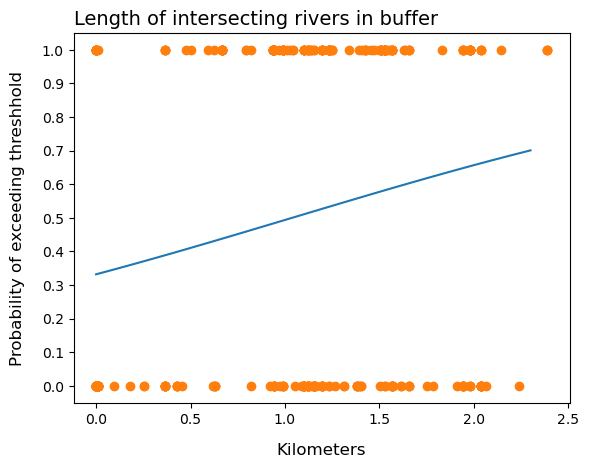

In [9]:
log_of = to_test[["location", "failed"]].copy()

log_of["r-length"] = log_of.location.apply(lambda x: ints_ct.loc[ints_ct.location == x, "r-length"].values[0])
log_of["r-length"] = log_of["r-length"]/1000
log_of.rename(columns={'r-length':'r_length'}, inplace=True)

obj_min, obj_max = log_of["r_length"].min(), log_of["r_length"].max()

formula = 'failed ~ r_length'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['r_length']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

fig, ax = plt.subplots()

ax.plot(xs, ps_x)
ax.plot(log_of["r_length"], log_of["failed"], 'o')
ax.set_title("Length of intersecting rivers in buffer", fontsize=14, loc='left')

ax.set_xlabel("Kilometers", fontsize=12,labelpad=12)
ax.set_ylabel("Probability of exceeding threshhold", fontsize=12, labelpad=12)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.1))
plt.show()

In [10]:
threshhold

0.23

In [11]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 10/05/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [12]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: main

scipy      : 1.10.1
numpy      : 1.24.2
IPython    : 8.12.0
json       : 2.0.9
PIL        : 9.5.0
seaborn    : 0.12.2
matplotlib : 3.7.1
pandas     : 2.0.0
statsmodels: 0.13.5

